## Results for the Annual Summer Irrigated Cropping Area (SICA) project


In [1]:
import numpy as np
import xarray as xr
import geopandas as gpd
import pandas as pd
from osgeo import gdal, ogr
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pathlib import Path
from shapely.geometry import Polygon, MultiPolygon
import warnings
from multiprocessing import Pool

### Entire catchment plot

This code will produce a timeseries of annual irrigated area aggregated acrosss the entire Northern Murray Darling Basin

In [2]:
directory = "/g/data/r78/cb3058/dea-notebooks/ICE_project/results/nmdb/"
suffix = "_Irrigated_OEHandLS_masked"

In [4]:
#list of years to help for-loop iterate through folders
x = range(1987,2019,1)
years = []
for i in x:
    nextyear = str(i + 1)[2:]
    y = str(i) + "_" + nextyear
    years.append(str(y))
# removing years that didn't work
years =  [e for e in years if e not in ('2011_12', '2012_13')]
years.sort()

folders = os.listdir(directory)
folders.sort()

area_a = []
def getIrrigatedArea(shp):
    irr = gpd.read_file(shp)
    area_a.append(irr.area.sum() / 10000)

#grab sum of irrigated area for each each and add to dataframe
for year, folder in zip(years, folders): 
    #progress indicator
    print("\r", "working on year: " + year, end = '')
    getIrrigatedArea(directory+folder+"/"+"nmdb_Summer"+ year + suffix+".shp")

#convert years back into integers for plot
years_dt = []
for i in years:
    x = int(i[:-3])
    years_dt.append(x)
#create pandas dataframe
df = pd.DataFrame.from_dict({'year':years_dt, 'irrigated area':area_a})#, '0.75+0.8':area_b, '0.70+0.75+0.8':area_c})
df = df.set_index('year')
df.to_csv("results/nmdb_plots/csvs/NMDB_annual_area.csv", header=True)

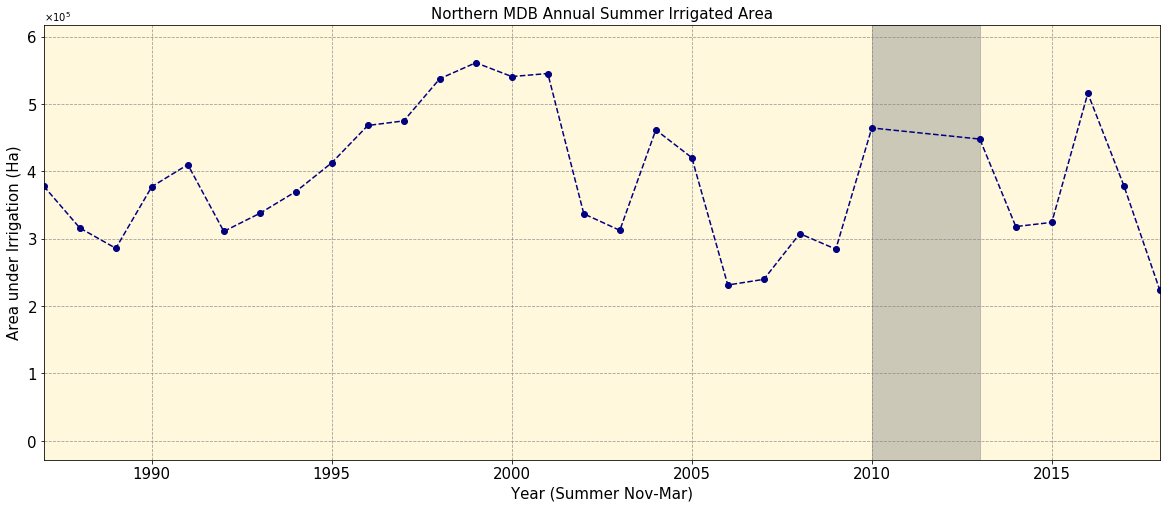

In [6]:
#plot annual irrigated area
fontsize = 15
df = pd.read_csv("results/nmdb_plots/csvs/NMDB_annual_area.csv", index_col=0)
ax = df.plot(colormap='jet', linestyle='--', marker='o', legend=False,figsize=(20,8))
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.set_xlabel('Year (Summer Nov-Mar)', fontsize=fontsize)
ax.set_ylabel('Area under Irrigation (Ha)', fontsize=fontsize)
ax.set_ylim(bottom=-int((df['irrigated area'].max()*0.05)), top=(df['irrigated area'].max()+(df['irrigated area'].max()*0.1)))
ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 3), useMathText=True)
plt.tick_params(labelsize=fontsize)
ax.grid(True, linestyle='--', alpha=0.75, color="gray")
ax.axvspan(2010, 2013, alpha=0.4, color='grey')
ax.set_facecolor('cornsilk')
ax.set_title("Northern MDB Annual Summer Irrigated Area", fontsize=fontsize)
#     plt.tight_layout()
plt.savefig("results/nmdb_plots/plots/NMDB_annual_irrigated_area.pdf",
           orientation='landscape')

#### Cumulative whole-of-catchment plot

Create the csvs for this plot with the cumulative area section at the bottom

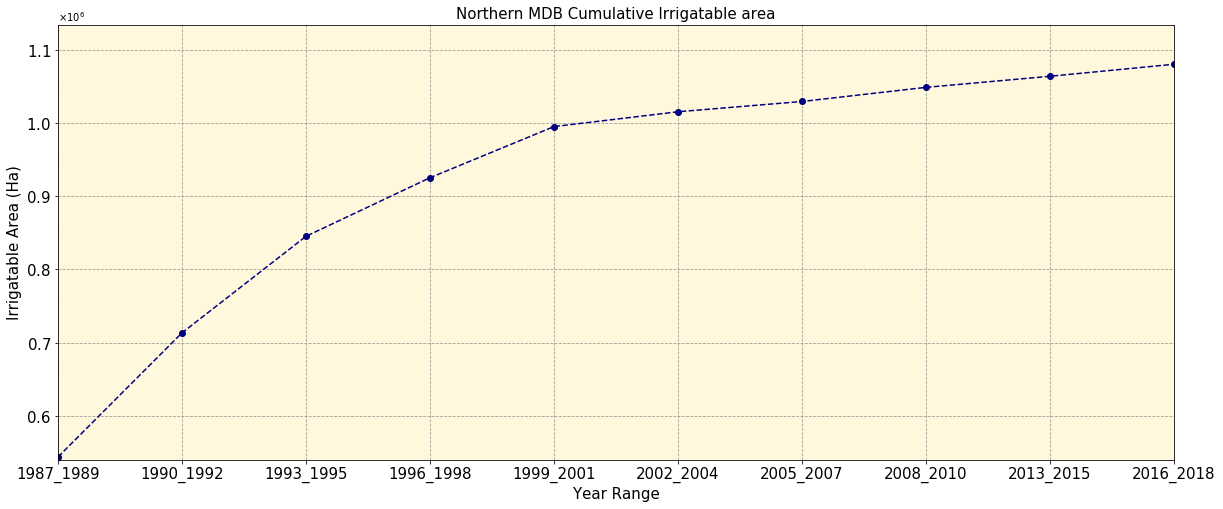

In [16]:
fontsize = 15
df = pd.read_csv("results/nmdb_plots/csvs/NMDB_cumulative_area.csv", index_col=0)
ax = df.plot(colormap='jet', linestyle='--', marker='o', legend=False,figsize=(20,8))
# ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.set_xlabel('Year Range', fontsize=fontsize)
ax.set_ylabel('Irrigatable Area (Ha)', fontsize=fontsize)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 3), useMathText=True)
ax.set_ylim(bottom=int((df['NMDB'].max()*0.50)), top=(df['NMDB'].max()+(df['NMDB'].max()*0.05)))
plt.tick_params(labelsize=fontsize)
ax.grid(True, linestyle='--', alpha=0.75, color="gray")
ax.set_facecolor('cornsilk')
ax.set_title("Northern MDB Cumulative Irrigatable area", fontsize=fontsize)
# plt.tight_layout()
plt.savefig("results/nmdb_plots/plots/NMDB_cumulative_area.pdf",
           orientation='landscape')

### Sub-catchment plots

This script will produce a timeseries of irrigated area for each subcatchment in the directory.  This script is slow to run beacause the geopandas overlay functions are cumbersome (this is true of other libraries as well). R-tree spatial indexing is NOT used as it is imprecise with the clip boundaries.

In [ ]:
directory = "/g/data/r78/cb3058/dea-notebooks/ICE_project/results/nmdb/"
individual_catchments_dir ="/g/data/r78/cb3058/dea-notebooks/ICE_project/data/spatial/nmdb_individual_catchments/"
suffix = "_Irrigated_OEHandLS_masked"

In [ ]:
#generate all the filenames we need for the loops
catchments = []
for file in os.listdir(individual_catchments_dir):
    if file.endswith(".shp"):
        catchments.append(os.path.join(individual_catchments_dir, file))

x = range(1987,2019,1)
years = []
for i in x:
    nextyear = str(i + 1)[2:]
    y = str(i) + "_" + nextyear
    years.append(str(y))
# removing years that didn't work due to bad satellite coverage
years =  [e for e in years if e not in ('2011_12', '2012_13')]
years.sort()

years_dt = []
for i in years:
    x = int(i[:-3])
    years_dt.append(x)

folders = os.listdir(directory)
folders.sort()

In [ ]:
#multithreaded version
def subcatchmentarea(catchment):
    print("working on "+ catchment[85:-4])
    area_a = []
    for year, folder in zip(years, folders): 
        #progress indicator
        print("\r", "working on "+ catchment[85:-4] + ": " + year, end = '')
        #get the irrigated area shapefile
        irr = gpd.read_file(directory+folder+"/"+"nmdb_Summer"+ year + suffix+".shp")
        catch = gpd.read_file(catchment)
        irr_clip = gpd.overlay(irr, catch, how='intersection')
        area_a.append(irr_clip.area.sum() / 10000) 
    #create pandas dataframe
    df = pd.DataFrame.from_dict({'year':years_dt, 'irr_area':area_a})
    df = df.set_index('year')
    df.to_csv("results/nmdb_plots/csvs/annual_area/" + catchment[85:-4] + "_annual_area.csv", header=True)
    print("finished "+ catchment[85:-4])

#singlethreaded version
# for i in catchments:
#     subcatchmentarea(i)

# multithreaded version
pool = Pool(4)    
pool.map(subcatchmentarea, catchments)

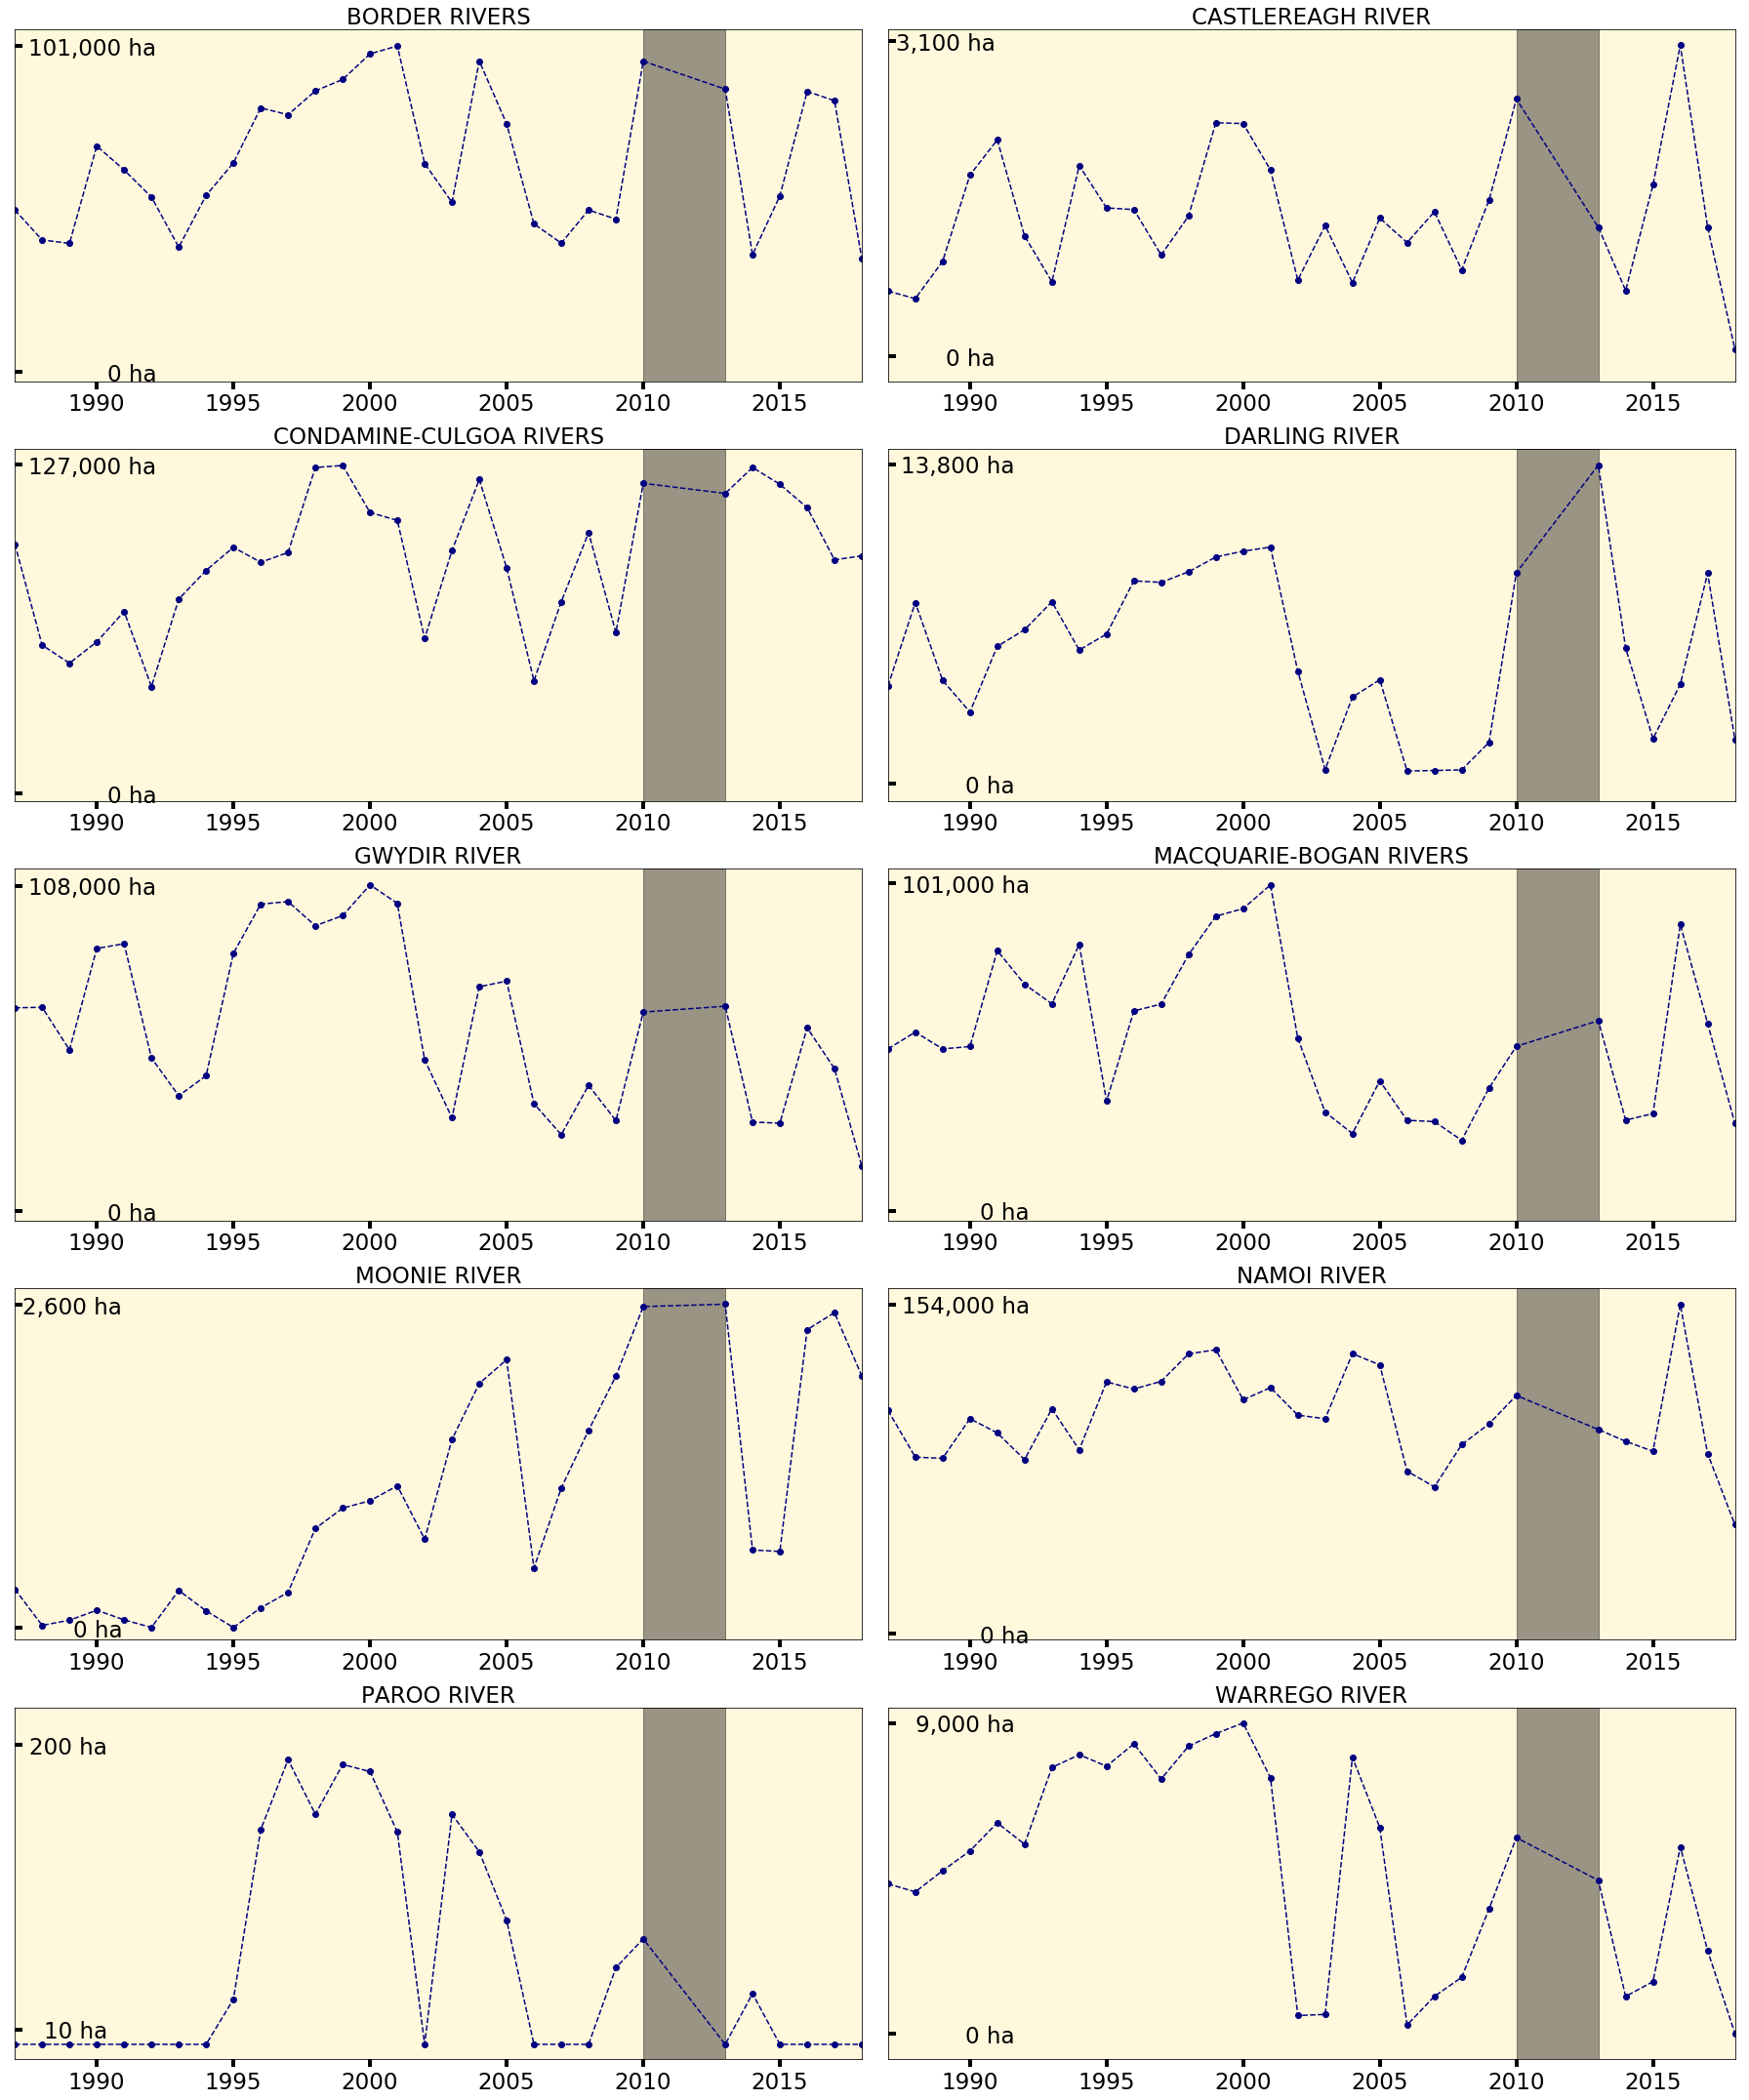

In [26]:
#create plot and save
folder = "/g/data/r78/cb3058/dea-notebooks/ICE_project/results/nmdb_plots/csvs/annual_area/"

fig, axs = plt.subplots(5,2, figsize=(25, 30), facecolor='w', edgecolor='k')
files = os.listdir(folder)
files.sort()

for ax,file in zip(axs.ravel(), files):
    fontsize = 23
    df = pd.read_csv(folder+file, index_col=0)
    df.plot(ax=ax,colormap='jet', linestyle='--', marker='o', legend = False)
    col_name = 'irr_area'
    if file[:-16] == 'PAROO RIVER':
        t = [10, 200]
        bottom = -10
        top = 225
        ax.set_ylim(bottom=bottom, top=top)
        ax.set_yticks(t)
        ax.set_yticklabels([str(i)+" ha" for i in t])
        ax.tick_params(axis='y', direction='in', pad=-95)
    elif file[:-16] == 'MOONIE RIVER':
        t = [0, round(int(df[col_name].max()), -2)]
        bottom = -100
        top = df[col_name].max()+(df[col_name].max()*0.05)
        ax.set_ylim(bottom=bottom, top=top)
        ax.set_yticks(t)
        ax.set_yticklabels([format(i,",")+" ha" for i in t])
        ax.tick_params(axis='y', direction='in', pad=-110)
    elif file[:-16] == 'CASTLEREAGH RIVER':
        t = [0, round(int(df[col_name].max()), -2)]
        bottom = -250
        top = df[col_name].max()+(df[col_name].max()*0.05)
        ax.set_ylim(bottom=bottom, top=top)
        ax.set_yticks(t)
        ax.set_yticklabels([format(i,",")+" ha" for i in t])
        ax.tick_params(axis='y', direction='in', pad=-110)
    elif file[:-16] == 'DARLING RIVER' or file[:-16] == 'WARREGO RIVER':
        t = [0, round(int(df[col_name].max()), -2)]
        bottom = -750
        top = df[col_name].max()+(df[col_name].max()*0.05)
        ax.set_ylim(bottom=bottom, top=top)
        ax.set_yticks(t)
        ax.set_yticklabels([format(i,",")+" ha" for i in t])
        ax.tick_params(axis='y', direction='in', pad=-130)
    else:
        t = [0 , round(int(df[col_name].max()), -3)]
        bottom = -3000
        top = df[col_name].max()+(df[col_name].max()*0.05)
        ax.set_ylim(bottom=bottom, top=top)
        ax.set_yticks(t)
        ax.set_yticklabels([format(i,",")+" ha" for i in t])
        ax.tick_params(axis='y', direction='in', pad=-145)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.xaxis.set_label_text("")
#     ax.grid(True, linestyle='--', alpha=0.75, axis='y', color="gray")
    ax.axvspan(2010, 2013, alpha=0.4, color='k')
    ax.tick_params(length=8, width=4,labelsize=fontsize)
    ax.set_title(file[:-16], fontsize=fontsize)
    ax.set_facecolor('cornsilk')

plt.tight_layout()
plt.savefig("results/nmdb_plots/plots/NMDB_annual_area_subcatchment.pdf",
   orientation='portarait', dpi=300)

### Epochal Change in Irrigated Area

#### Epochal change in spatial extent of irrigation

This section divides the analysis into distinct epochs: 1987-1995, 1996-2012, and 2013-2019
and finds the region under irrigation during each epoch.  This allows for spatially showing the growth in irrigation in a simple overlay plot.

In [28]:
directory = "/g/data/r78/cb3058/dea-notebooks/ICE_project/results/nmdb/"
individual_catchments_dir ="/g/data/r78/cb3058/dea-notebooks/ICE_project/data/spatial/nmdb_individual_catchments/"
AOI = "nmdb_Summer"
suffix = "_Irrigated_OEHandLS_masked"

In [41]:
#create list of catchment shapefiles
catchments = []
for file in os.listdir(individual_catchments_dir):
    if file.endswith(".shp"):
        catchments.append(os.path.join(individual_catchments_dir, file))

#time ranges
t1 = [str(t) for t in range(1987,1996,1)]
t2 = [str(t) for t in range(1996,2012,1)]
t2 = [e for e in t2 if e not in ('2011')]
t3 = [str(t) for t in range(2012,2019,1)]
t3 = [e for e in t3 if e not in ('2012')]

In [30]:
def cliptocatchment(t):
    #progress indicator
    print("\r", "working on "+catchment[85:-4]+": "+t+".", end = '')
    nextyear= str(int(t)+1)[2:]
    irr = gpd.read_file(directory+AOI+t+"_"+nextyear+"/"+AOI+t+"_"+nextyear+suffix+".shp")
    catch = gpd.read_file(catchment)
    irr = gpd.overlay(irr, catch, how='intersection') #doing it this way because its more accurate.
    shapes.append(irr)

def unionyears(timelist):
    for t in timelist:
        warnings.filterwarnings("ignore")
        cliptocatchment(t)
    try:
        warnings.filterwarnings("ignore")
        x = pd.concat(shapes)
        x['DISS_ID'] = 1
        x = x.dissolve(by='DISS_ID', aggfunc='sum')
        x['year_range'] = timelist[0]+ "_"+timelist[-1]
        x['catchment'] = catchment[85:-4]
        x.to_file(directory[:-1] + "_plots/shapes/"+timelist[0]+"_"+timelist[-1]+"/"+catchment[85:-4]+"_"+timelist[0]+ "_"+timelist[-1]+".shp")
    except:
        print(" Failed to export "+ catchment[85:-4])
        pass 

In [42]:
for catchment in catchments:
    shapes=[]
    unionyears(t1)

 working on NAMOI RIVER: 1995.

In [43]:
for catchment in catchments:
    shapes=[]
    unionyears(t2)

 working on NAMOI RIVER: 2010.

In [44]:
for catchment in catchments:
    shapes=[]
    unionyears(t3)

 working on NAMOI RIVER: 2018.

### Cumulative sum timeseries

The script is divided into four sections: 

1. The first section clips the analysis to sub-catchments and then unions three concurrent years of irrigation together successively. ie. years 1987-1990 are unioned, then 1991-1994 etc. These unioned shapefiles are exported to a folder called 'interim'.  This code will take a long time to run. (I should consider multithreading it).

2. The second part of the script finds the difference in irrigated area between adjacent time ranges (for each sub-catchment) ie. difference between '1987-1990' and '1991-1994' etc.  The cumulative sum is then computed on these areal differences, and the result is added to a dataframe and exported as a csv file. This section has been multithreaded but will still take a long time to complete.

3. The 3rd part of the script creates pdf plots of the subcatchment cumulative timeseries in the exported csv.

4. The fourth section creates a cumulative time-series plot for the entire NMDB

N.B.  A shortcoming of this approach: if a paddock is irrigated in the period of 1987-1990, but then is not irrigated in 1991-1994, and then is again irrigated in 1995-1998, it will be double counted in the 'cumulative new-area' timeseries.  Ideally this script would union all subsequent years before comparing it to a new time-range, but then the unions would become very very large later in the timeseries and therefore take prohibitively long to run (script already takes hours to compute).  I checked this approach on two catchments (Namoi and Border Rivers) and nowhere did the double accounting occur.



In [7]:
directory = "/g/data/r78/cb3058/dea-notebooks/ICE_project/results/nmdb/"
individual_catchments_dir ="/g/data/r78/cb3058/dea-notebooks/ICE_project/data/spatial/nmdb/"
AOI = "nmdb_Summer"
interim_results = "/g/data/r78/cb3058/dea-notebooks/ICE_project/results/nmdb_plots/shapes/interim_NMDB/"
suffix = "_Irrigated_OEHandLS_masked"

#### Part 1.

Creating the 3-yearly unioned files

In [9]:
#create list of catchment shapefiles
catchments = []
for file in os.listdir(individual_catchments_dir):
    if file.endswith(".shp"):
        catchments.append(os.path.join(individual_catchments_dir, file))

#time ranges
t1 = [str(t) for t in range(1987,1990,1)]
t2 = [str(t) for t in range(1990,1993,1)]
t3 = [str(t) for t in range(1993,1996,1)]
t4 = [str(t) for t in range(1996,1999,1)]
t5 = [str(t) for t in range(1999,2002,1)]
t6 = [str(t) for t in range(2002,2005,1)]
t7 = [str(t) for t in range(2005,2008,1)]
t8 = [str(t) for t in range(2008,2011,1)]
t9 = [str(t) for t in range(2013,2016,1)]
t10 = [str(t) for t in range(2016,2019,1)]

timerangelist=[t1,t2,t3,t4,t5,t6,t7,t8,t9,t10]

In [10]:
for i in timerangelist:
    if not os.path.exists(interim_results+i[0]+"_"+i[-1]):
        os.mkdir(interim_results+i[0]+"_"+i[-1])

In [11]:
def cliptocatchment(t, shapes, catchment):
    #progress indicator
    try:
        nextyear= str(int(t)+1)[2:]
        irr = gpd.read_file(directory+AOI+t+"_"+nextyear+"/"+AOI+t+"_"+nextyear+suffix+".shp")
        catch = gpd.read_file(catchment)
        irr = gpd.overlay(irr, catch, how='intersection')
        shapes.append(irr)
    except:
        pass

def unionyears(timerangelist, shapes, catchment):
    for timerange in timerangelist:
        for t in timerange:
            warnings.filterwarnings("ignore")
            cliptocatchment(t, shapes, catchment)
        try:
            warnings.filterwarnings("ignore")
            x = pd.concat(shapes)
            x['DISS_ID'] = 1
            x = x.dissolve(by='DISS_ID', aggfunc='sum')
            x['year_range'] = timerange[0]+ "_"+timerange[-1]
            x['catchment'] = catchment[63:-4]
            x.to_file(interim_results +timerange[0]+"_"+timerange[-1]+"/"+catchment[63:-4]+"_"+timerange[0]+ "_"+timerange[-1]+".shp")
        except:
            print(" Failed to export "+ catchment[63:-4] +" "+ timerange[0]+"_"+timerange[-1])
            pass

In [12]:
# This will generate all of our time-range unioned shapefiles
#--single thread----NEED TO ALTER FUNCTIONS FOR THIS
# for catchment in catchments:
#     print("\r", "working on "+catchment[85:-4] + "...", end = '')
#     shapes=[]
#     unionyears(timerangelist)

#--multithreaded version---
def runFunc(catchment):
    print("working on "+catchment[63:-4] + "...")
    shapes=[]
    unionyears(timerangelist, shapes, catchment)
    
pool = Pool(1)    
pool.map(runFunc, catchments)

working on NMDB...


[None]

#### Part 2.  

Multithreaded to speed up v. slow union operations

In [13]:
from shapely.geometry import JOIN_STYLE
def areaofFirstYear(catchment, area_list):
    #open the first timerange
    try:
        firstyear = gpd.read_file(interim_results+ "1987_1989/" + catchment + "_1987_1989.shp")
        #add area to list
        area_list.append((firstyear.area.sum()/ 10000))
    except:
        area_list.append(0)
        
def getdifferenceAreas(yr1, yr2, catchment, area_list):
    df1 = gpd.read_file(interim_results+ yr1+ "/"+ catchment + "_" + yr1 + ".shp")
    df2 = gpd.read_file(interim_results+ yr2+ "/"+ catchment + "_"+ yr2 + ".shp")
    try:
        diff = gpd.overlay(df2, df1, how='difference')
        area_list.append(float(diff.area / 10000))
    except (TopologicalError, TopologyException):
        print('encountered topology error...passing')
        pass

def getcumulativeNewAreas(catchment, area_list):
    areaofFirstYear(catchment, area_list)
    for i in range(1, len(yearstrings)):
        print("\r", " : "+ yearstrings[i], end = '')
        try:
            getdifferenceAreas(yearstrings[i-1],yearstrings[i], catchment, area_list)
        except:
            print(". Didn't find shapefile.")
            area_list.append(0) #adding area = zero for years when catchment has no irrigation   

In [14]:
#get a list of catchment names as input to functions
catchments = []
for file in os.listdir(individual_catchments_dir):
    if file.endswith(".shp"):
        catchments.append(file[:-4])

# #--Single Threaded version-------
# yearstrings = ['1987_1989','1990_1992', '1993_1995',
#                 '1996_1998', '1999_2001', '2002_2004',
#                 '2005_2007', '2008_2010', '2013_2015', '2016_2018']        
# #create empty dataframe to add results too
# df = pd.DataFrame(index=yearstrings)

# for catch in catchments:
#     print(" ...working on "+ catch)
#     area_list = []
#     getcumulativeNewAreas(catch, area_list)
#     df[catch] = area_list

# df = df.cumsum(axis = 0)
# df.to_csv('results/nmdb_plots/csvs/NMDB_cumulative_area.csv', header=True)   

#--Multithreaded version-----------

yearstrings = ['1987_1989','1990_1992', '1993_1995',
                '1996_1998', '1999_2001', '2002_2004',
                '2005_2007', '2008_2010', '2013_2015', '2016_2018'] 
def runPart2(catch):
    print(" ...working on "+ catch)
    area_list = []
    getcumulativeNewAreas(catch, area_list)
    #create empty dataframe to add results too
    df = pd.DataFrame(index=yearstrings)
    df[catch] = area_list
    df = df.cumsum(axis = 0)
    df.to_csv("results/nmdb_plots/csvs/cumulative/" + catch + "_cumulative_area.csv", header=True)

pool = Pool(1)    
pool.map(runPart2, catchments)

 ...working on NMDB


[None]

#### Part 3 

plotting of sub-catchment cumulative area

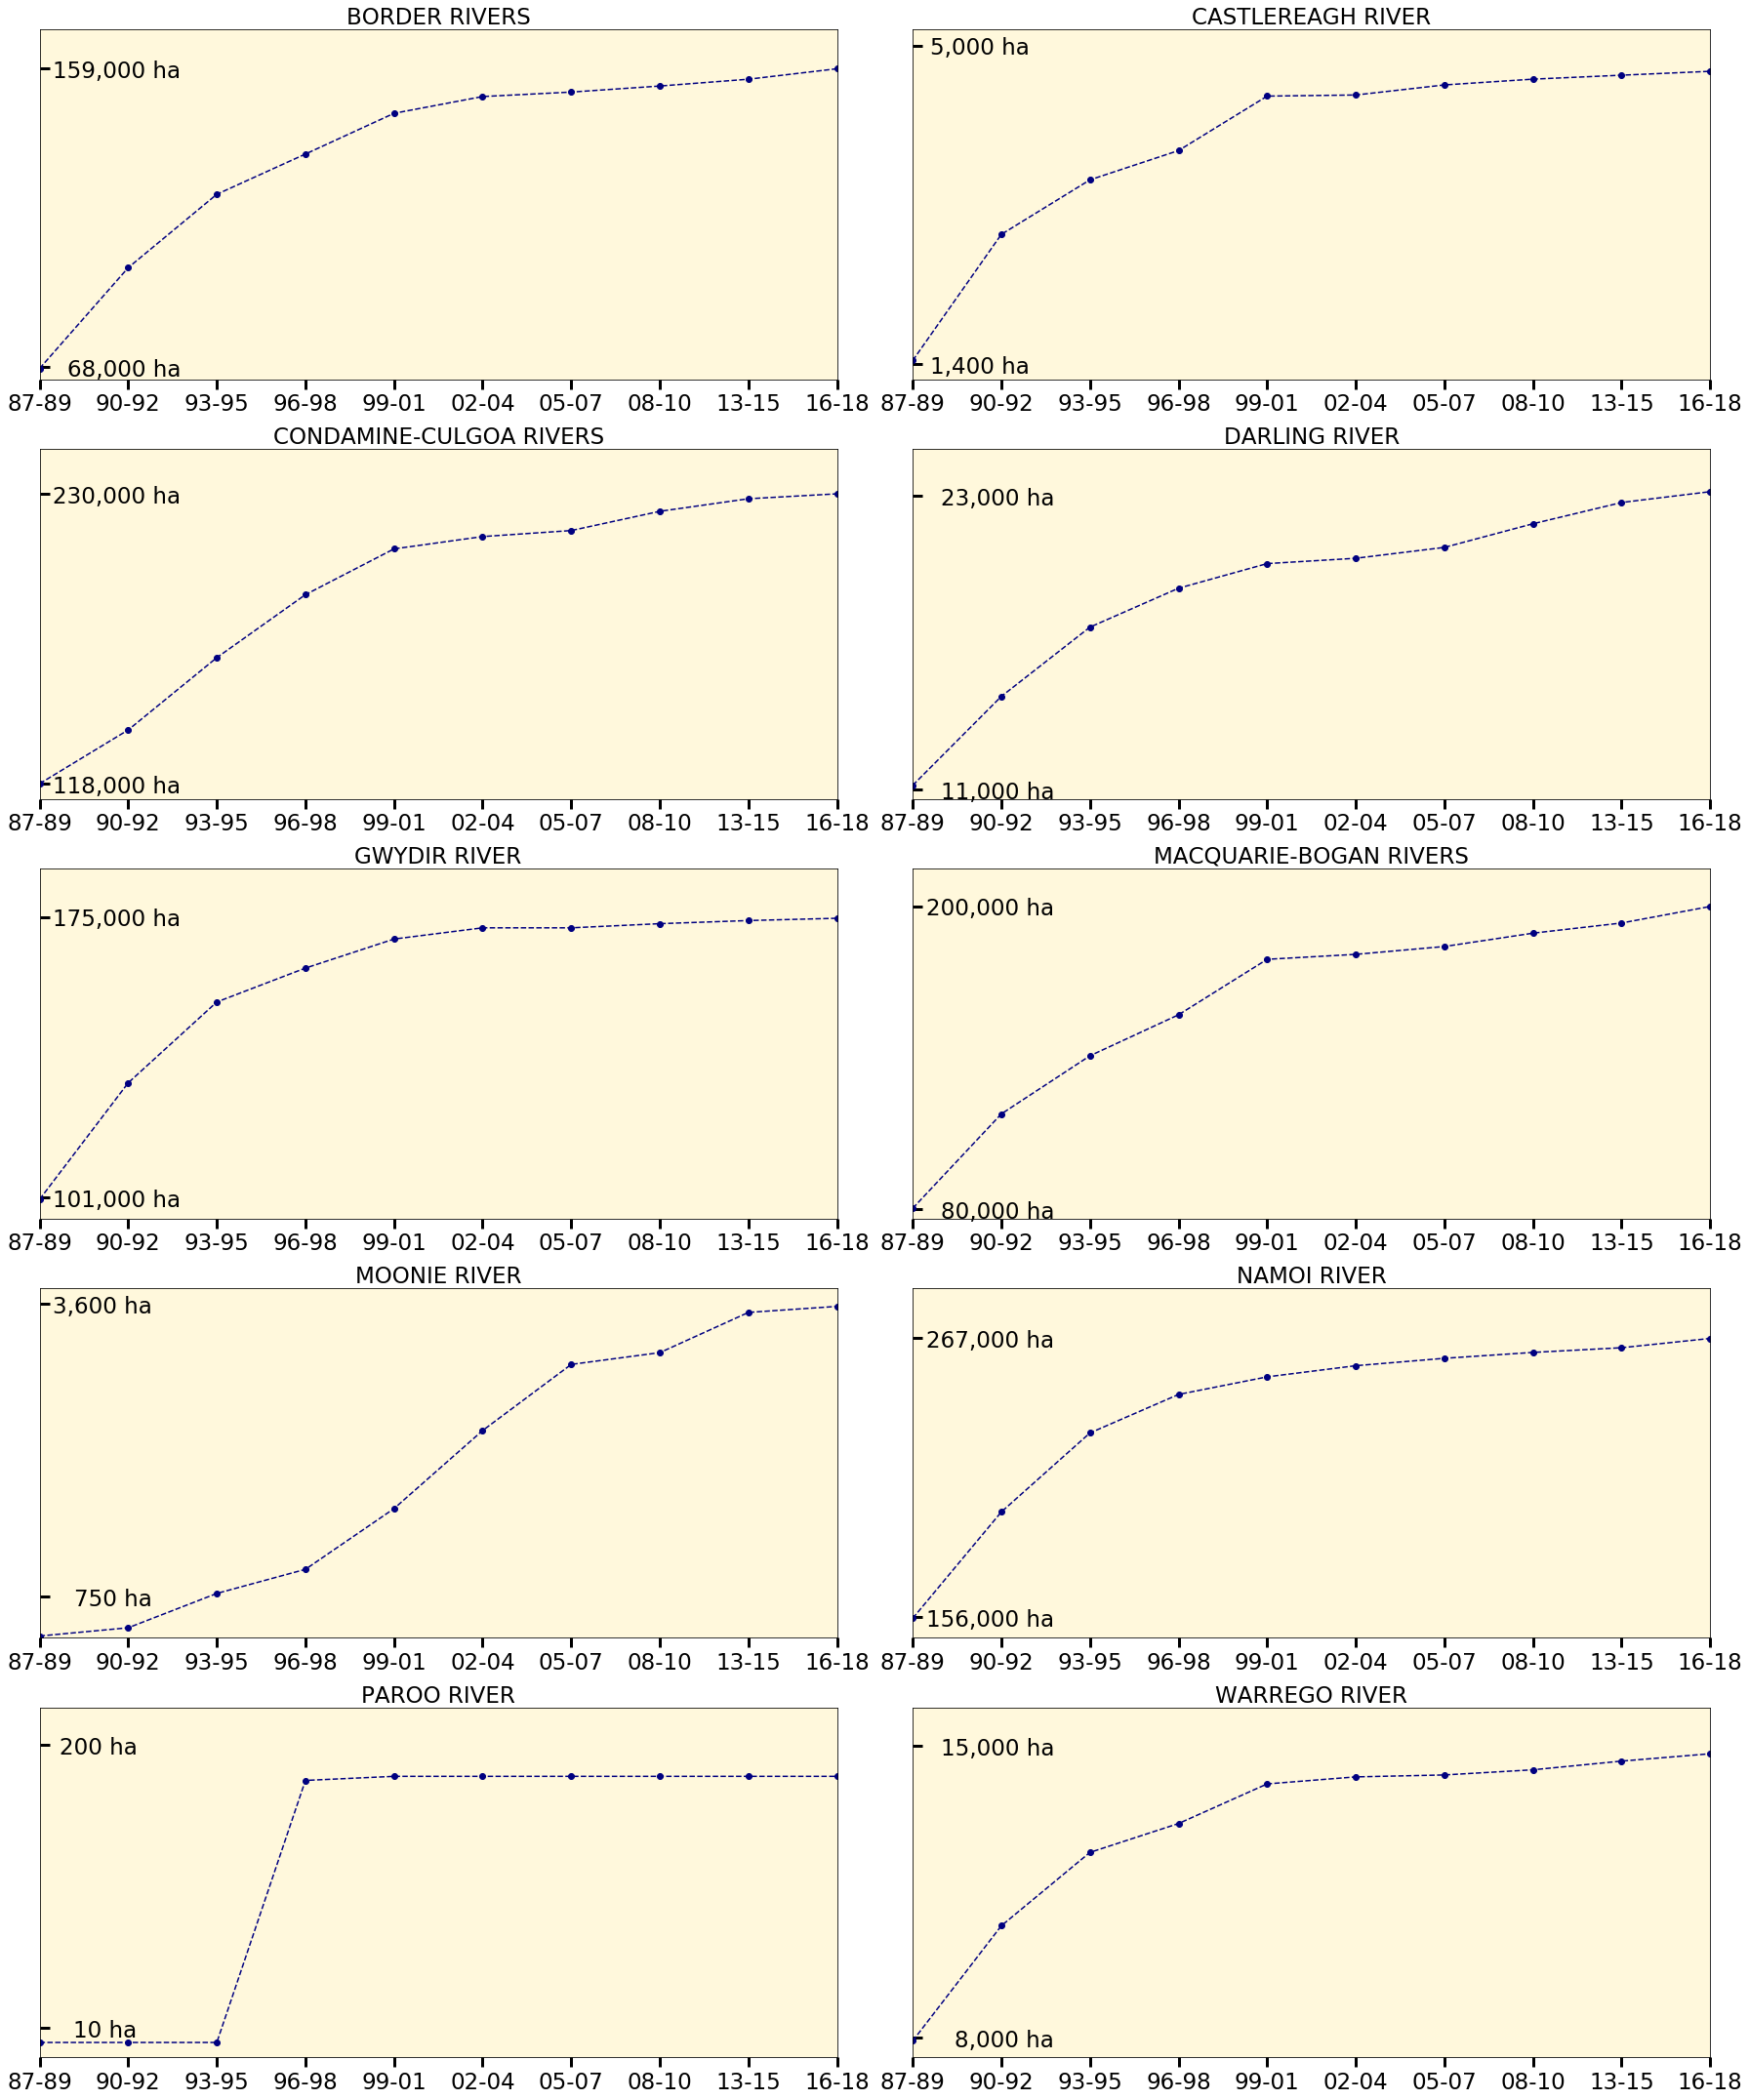

In [23]:
#create plot and save
folder = "/g/data/r78/cb3058/dea-notebooks/ICE_project/results/nmdb_plots/csvs/cumulative/"

fig, axs = plt.subplots(5,2, figsize=(25, 30), edgecolor='k')
files = os.listdir(folder)
files.sort()
for ax,file in zip(axs.ravel(), files):
    fontsize = 23
    df = pd.read_csv(folder+file, index_col=0)
    df.plot(ax=ax,colormap='jet', linestyle='--', marker='o', legend = False)
    if file[:-20] == 'PAROO RIVER':
        t = [10, 200]
        bottom = -10
        top = 225
        ax.set_ylim(bottom=bottom, top=top)
        ax.set_yticks(t)
        ax.set_yticklabels([str(i)+" ha" for i in t])
        ax.tick_params(axis='y', direction='in', pad=-100)
    elif file[:-20] == 'MOONIE RIVER':
        t = [750, round(int(df[file[:-20]].max()), -2)]
        bottom = df[file[:-20]].min() - df[file[:-20]].min()*0.05
        top = df[file[:-20]].max()+(df[file[:-20]].max()*0.05)
        ax.set_ylim(bottom=bottom, top=top)
        ax.set_yticks(t)
        ax.set_yticklabels([format(i,",")+" ha" for i in t])
        ax.tick_params(axis='y', direction='in', pad=-115)
    elif file[:-20] == 'CASTLEREAGH RIVER':
        t = [round(int(df[file[:-20]].min()), -2) , round(int(df[file[:-20]].max()), -3)]
        bottom = df[file[:-20]].min() - df[file[:-20]].min()*0.15
        top = df[file[:-20]].max()+(df[file[:-20]].max()*0.1)
        ax.set_ylim(bottom=bottom, top=top)
        ax.set_yticks(t)
        ax.set_yticklabels([format(i,",")+" ha" for i in t])
        ax.tick_params(axis='y', direction='in', pad=-120)
    else:
        t = [round(int(df[file[:-20]].min()), -3) , round(int(df[file[:-20]].max()), -3)]
        bottom = df[file[:-20]].min() - df[file[:-20]].min()*0.05
        top = df[file[:-20]].max()+(df[file[:-20]].max()*0.075)
        ax.set_ylim(bottom=bottom, top=top)
        ax.set_yticks(t)
        ax.set_yticklabels([format(i,",")+" ha" for i in t])
        ax.tick_params(axis='y', direction='in', pad=-145)
    ax.xaxis.set_label_text("")
    ax.set_xticklabels(["87-89","90-92","93-95","96-98","99-01","02-04", "05-07",
                       "08-10", "13-15", "16-18"])
#     for tick in ax.xaxis.get_major_ticks()[1::2]: #This offsets X-axis labels
#         tick.set_pad(15)
    ax.tick_params(length=10, width=3, labelsize=fontsize)
    ax.set_title(file[:-20], fontsize=fontsize)
    ax.set_facecolor('cornsilk')
plt.tight_layout()
plt.savefig("results/nmdb_plots/plots/NMDB_cumulative_area_subcatchment.pdf",
   orientation='portarait', dpi=300)
